## TODO
* Add O2C and C2O seasonality
* Look at diff symbols
* Look at fund flows

## Key Takeaways
* ...


In the [first post](sell_in_may.html) of this short series, we covered several seasonality patterns for large cap equities (i.e, SPY), most of which continue to be in effect.  

The findings of that exercise sparked interest in what similar seasonal patterns may exist in other asset classes.  This post will pick up where that post left off, looking at "risk-off" assets which exhibit low (or negative) correlation to equities.  



In [61]:

## Replace this section of imports with your preferred
## data download/access interface.  This calls a 
## proprietary set of methods (ie they won't work for you)

import sys
sys.path.append('/anaconda/')
import config

sys.path.append(config.REPO_ROOT+'data/')
from prices.eod import read

####### Below here are standard python packages ######
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display
import seaborn as sns

from IPython.core.display import HTML,Image


## Load Data
symbols = ['SPY','IWM','AGG','LQD','IEF','MUB','GLD']
#symbols = ['SPY','IWM','AGG','LQD','JNK','IEF']
prices = read.get_symbols_close(symbols,adjusted=True)
returns = prices.pct_change()
log_ret = np.log(prices).diff()



### Month-of-year seasonality

Again, we'll start with month-of-year returns for several asset classes.  Note that I'm making use of the seaborn library's excellent `clustermap()` method to both visually represent patterns in asset classes _and_ to group the assets by similarity (using Euclidean distance between the average monthly returns vectors of each column).  

_Note that the values plotted are z-score values (important for accurate clustering)_.

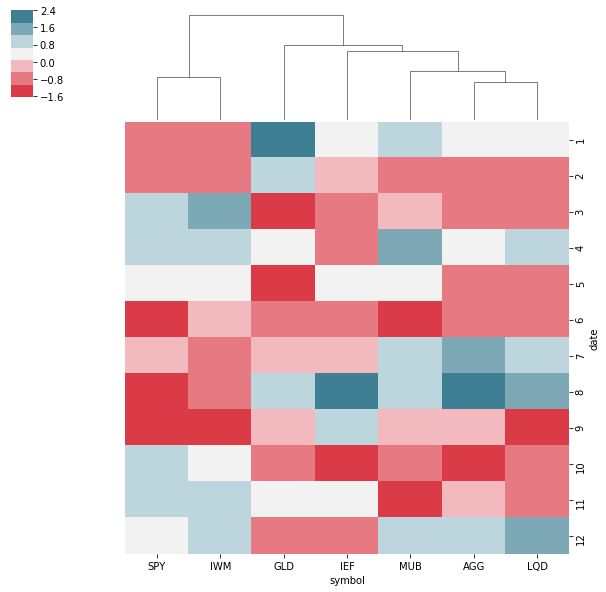

In [133]:
by_month = log_ret.resample('BM').sum()
by_month[by_month==0.0] = None 
# because months prior to fund launch are summed to 0.0000

avg_monthly = by_month.groupby(by_month.index.month).mean()

sns.clustermap(avg_monthly[symbols],row_cluster=False,z_score=True, metric='euclidean',\
               cmap=sns.diverging_palette(10, 220, sep=20, n=7))
## Notes: 
# should use either z_score =True or standard_scale = True for accurate clustering
# Uses Euclidean distance as metric for determining cluster

Clearly, the seasonal patterns we saw in the [last post](sell_in_may.html) do not generalize across all instruments - which is a very good thing!  IWM (small cap equities) do more or less mimic the SPY patterns, but the "risk-off" assets generally perform well in the summer months of July and August, when equities had faltered.  

We might consider a strategy of shifting from risk-on (e.g., SPY) to risk-off (e.g., IEF) for June to September.

In [149]:
rotation_results = pd.Series(index=avg_monthly.index)
rotation_results.loc[[1,2,3,4,5,10,11,12]] = avg_monthly['SPY']
rotation_results.loc[[6,7,8,9]] = avg_monthly['IEF']
#
print("Returns:")
print(avg_monthly.SPY.sum())
print(rotation_results.sum())
print()
print("Sharpe:")
print(avg_monthly.SPY.sum()/(by_month.std()['SPY']*12**0.5))
print(rotation_results.sum()/(rotation_results.std()*12**0.5))


Returns:
0.09231732105877347
0.11971481651504569

Sharpe:
0.6495856298514646
5.2988969815087055


In [142]:
avg_monthly.SPY.std()*12**0.5

0.028825583962551884


Next, I'll plot the same for day-of-month.  

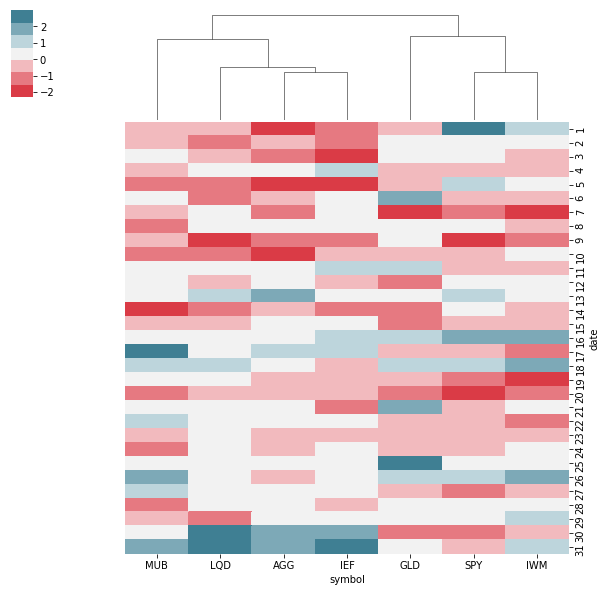

In [63]:
avg_day_of_month = log_ret.groupby(log_ret.index.day).mean()
sns.clustermap(avg_day_of_month[symbols],row_cluster=False,z_score= True,metric='euclidean',\
               cmap=sns.diverging_palette(10, 220, sep=20, n=7))

This is a bit messy, but I think the dominant pattern is weakness within all "risk-off" assets (treasurys, etc...) for the first 1/3 to 1/2 of the month, followed by a very strong end of month rally.  

Finally, plot a clustermap for day-of-week:

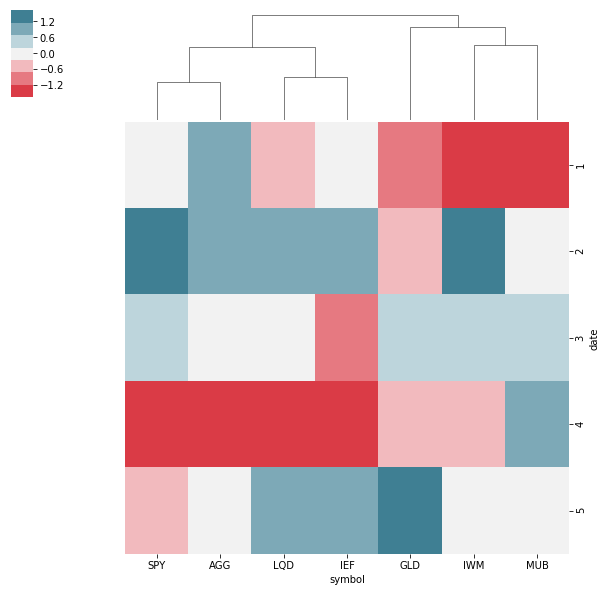

In [64]:
avg_day_of_week = log_ret.groupby(log_ret.index.weekday+1).mean()
sns.clustermap(avg_day_of_week[symbols],row_cluster=False,z_score= True,metric='euclidean',\
               cmap=sns.diverging_palette(10, 220, sep=20, n=7))

Again, a bit messy.  However, the most consistent pattern is "avoid Thursday" for risk-off assets like AGG, LQD, and IEF.  Anyone with a hypothesis as to why this might be, please do share!



### Observations
* Clusters form about as you'd expect.  The "risk-off" assets like Treasurys (IEF), munis (MUB), gold (GLD), and long volatility (VXX) tend to cluster together.  The "risk-on" assets like SPY, EEM, IXUS, and JNK tend to cluster together.
* Risk-off assets (Treasurys etc...) appear to follow the opposite of "sell in May", with weakness in November and December, when SPY and related were strongest.
* Within day-of-month, there are some _very_ strong patterns for fixed income, with negative days at the beginning of month and positive days at end of month.  
* Day of week shows very strong clustering of risk-off assets (outperform on Fridays).  There's an interesting clustering of underperformance on Mondays.  This may be a false correlation since some of these funds have much shorter time histories than others and may be reflecting that

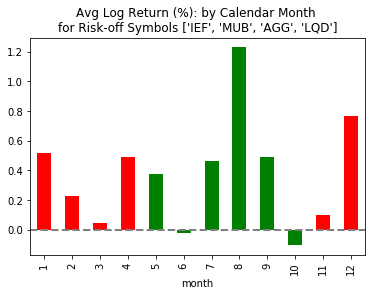

In [74]:
risk_off_symbols = ['IEF','MUB','AGG','LQD']

df = log_ret[symbols_1].mean(axis=1).dropna().to_frame(name='pct_chg')
by_month = df.resample('BM').sum()
by_month['month'] = by_month.index.month

title='Avg Log Return (%): by Calendar Month \nfor Risk-off Symbols {}'.format(risk_off_symbols)
s = (by_month.groupby('month').pct_chg.mean()*100)
my_colors = ['r','r','r','r','g','g','g','g','g','g','r','r',]
ax = s.plot(kind='bar',color=my_colors,title=title)
ax.axhline(y=0.00, color='grey', linestyle='--', lw=2)

Wow, maybe there's some truth to this myth!  It appears that there is a strong difference between the summer months (June to September) and the rest.  

From the above chart, it appears than we'd be well advised to sell on June 1st and buy back on September 30th.  However, to follow the commonly used interpretation of selling on May 1st and repurchasing on Oct 31st.  I'll group the data into those two periods and calculate the monthly average:

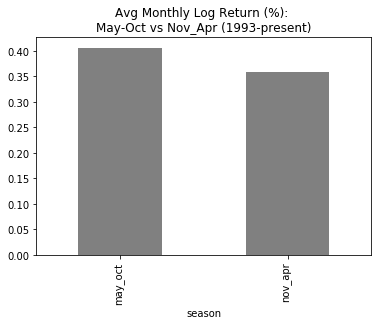

In [68]:
by_month['season'] = None
by_month.loc[by_month.month.between(5,10),'season'] = 'may_oct'
by_month.loc[~by_month.month.between(5,10),'season'] = 'nov_apr'

(by_month.groupby('season').pct_chg.mean()*100).plot.bar\
(title='Avg Monthly Log Return (%): \nMay-Oct vs Nov_Apr (1993-present)'\
 ,color='grey')


A significant difference.  The "winter" months are more than double the average return of the summer months.  But has this anomaly been taken out of the market by genius quants and vampire squid?  Let's look at this breakout by year:

Of these, the most interesting patterns, to me, are the day-of-week and day-of-month cycles.  

### Day of Week
I'll repeat the same analysis pattern as developed in the prior post (["Sell in May"](sell_in_may.html)), using a composite of four generally "risk-off" assets. You may choose create composites differently.  

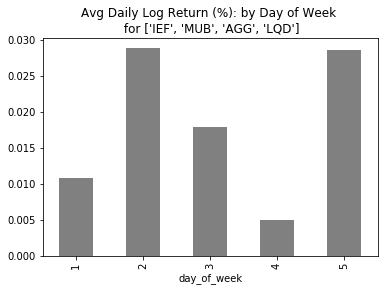

Text(0.5,1,"Avg Daily Log Return (%) by Part of Week\nFour Year Moving Average\n for ['IEF', 'MUB', 'AGG', 'LQD']")

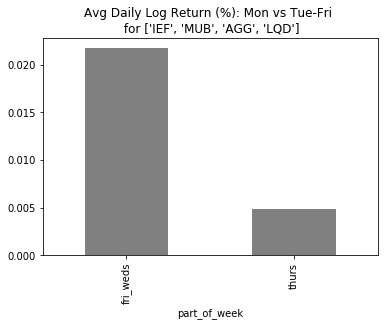

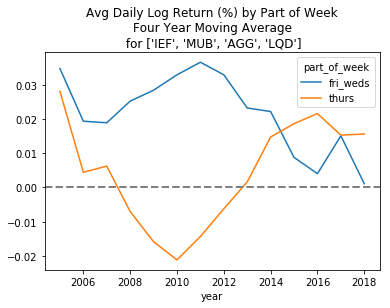

In [81]:
risk_off_symbols = ['IEF','MUB','AGG','LQD']

df = log_ret[risk_off_symbols].mean(axis=1).dropna().to_frame(name='pct_chg')

by_day = df
by_day['day_of_week'] = by_day.index.weekday+ 1

ax = (by_day.groupby('day_of_week').pct_chg.mean()*100).plot.bar\
(title='Avg Daily Log Return (%): by Day of Week \n for {}'.format(risk_off_symbols),color='grey')
plt.show()

by_day['part_of_week'] = None
by_day.loc[by_day.day_of_week ==4,'part_of_week'] = 'thurs'
by_day.loc[by_day.day_of_week !=4,'part_of_week'] = 'fri_weds'

(by_day.groupby('part_of_week').pct_chg.mean()*100).plot.bar\
(title='Avg Daily Log Return (%): Mon vs Tue-Fri \n for {}'.format(risk_off_symbols)\
 ,color='grey')

title='Avg Daily Log Return (%) by Part of Week\nFour Year Moving Average\n for {}'.format(risk_off_symbols)
by_day['year'] = by_day.index.year
ax = (by_day.groupby(['year','part_of_week']).pct_chg.mean().unstack().rolling(4).mean()*100).plot()
ax.axhline(y=0.00, color='grey', linestyle='--', lw=2)
ax.set_title(title)



The "avoid Thursday" for risk-off assets seemed to be remarkably useful until about 4 years ago, when it ceased to work.  I'll call this one busted.  Moving on to day-of-month, and following the same grouping and averaging approach:

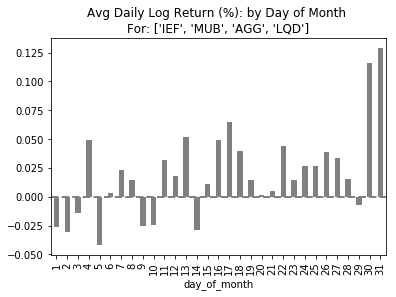

In [82]:
risk_off_symbols = ['IEF','MUB','AGG','LQD']
by_day = log_ret[risk_off_symbols].mean(axis=1).dropna().to_frame(name='pct_chg')
by_day['day_of_month'] = by_day.index.day 
title='Avg Daily Log Return (%): by Day of Month \nFor: {}'.format(symbols_1)
ax = (by_day.groupby('day_of_month').pct_chg.mean()*100).plot.bar(xlim=(1,31),title=title,color='grey')
ax.axhline(y=0.00, color='grey', linestyle='--', lw=2)

Here we see the same pattern as appeared in the clustermap.  I wonder if the end of month rally is being driven by the ex-div date, which I believe is usually the 1st of the month for these funds.  

_Note: this data is dividend-adjusted so there is no valid reason for this - just dividend harvesting and behavioral biases, IMO._

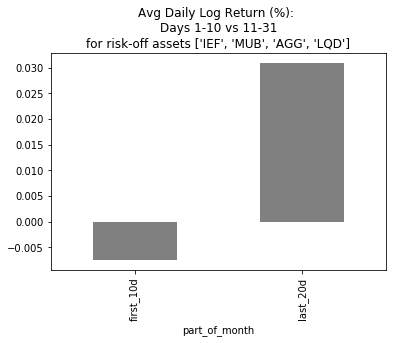

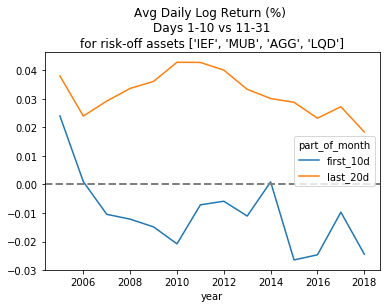

In [85]:
by_day['part_of_month'] = None
by_day.loc[by_day.index.day <=10,'part_of_month'] = 'first_10d'
by_day.loc[by_day.index.day >10,'part_of_month'] = 'last_20d'

(by_day.groupby('part_of_month').pct_chg.mean()*100).plot.bar\
(title='Avg Daily Log Return (%): \nDays 1-10 vs 11-31\nfor risk-off assets {}'.format(risk_off_symbols)\
 ,color='grey')

title='Avg Daily Log Return (%) \nDays 1-10 vs 11-31\nfor risk-off assets {}'.format(risk_off_symbols)
by_day['year'] = by_day.index.year
ax = (by_day.groupby(['year','part_of_month']).pct_chg.mean().unstack().rolling(4).mean()*100).plot(title=title)
ax.axhline(y=0.00, color='grey', linestyle='--', lw=2)

In contrast to the day-of-week anomaly, this day-of-month pattern seems to hold extremely well.  It's also an extremely tradeable anomaly, considering that it requires only one round-trip per month.  

baseline        0.043380
only_last_20    0.049227
dtype: float64


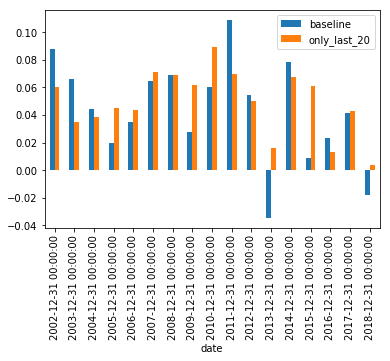

In [102]:
baseline = by_day.resample('A').pct_chg.sum()
only_last_20 = by_day[by_day.part_of_month=='last_20d'].resample('A').pct_chg.sum()
pd.DataFrame({'baseline':baseline,'only_last_20':only_last_20}).plot.bar()
print(pd.DataFrame({'baseline':baseline,'only_last_20':only_last_20}).mean())

Going to cash in the first 10 days of each month actually _increased_ annualized returns (log) by about 0.60%, while simultaneously lowering capital employed and volatility of returns.  Of the seasonality anomalies we've reviewed in this post and the previous, this appears to be the most robust and low risk.  



## Conclusion
... 

If the future looks anything like the past (insert standard disclaimer about past performance...) then rules of thumb might be:
* Sell on Labor Day and buy on Halloween - especially do this on election years!  This assumes that you've got a productive use for the cash!  
* Do your buying at Friday's close, do your selling at Wednesday's close
* Maximize your exposure at the end/beginning of months and during the early-middle part of the month, lighten up.
* Remember that, in most of these anomalies, _total_ return would decrease by only participating in part of the market since any positive return is better than sitting in cash.  Risk-adjusted returns would be significantly improved by only participating in the most favorable periods.  It's for each investor to decide what's important to them.  

I had intended to extend this analysis to other asset classes, but will save that for a future post.  I'd like to expand this to small caps, rest-of-world developed/emerging, fixed income, growth, value, etc... 


### One last thing...

If you've found this post useful, please follow [@data2alpha](https://twitter.com/data2alpha) on twitter and forward to a friend or colleague who may also find this topic interesting.

Finally, take a minute to leave a comment below.  Share your thoughts on this post or to offer an idea for future posts.  Thanks for reading!